Experiment with sentiment network prototyping in keras. Use Rotten Tomatoes dataset from https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews

In [1]:
# import libraries

import numpy as np

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Embedding, Dense, LSTM, Dropout, Activation, BatchNormalization
from keras.optimizers import Adam
from keras.utils import np_utils


Using TensorFlow backend.


In [2]:
import csv
import re

from nltk.corpus import stopwords

row_num = 0
training_data = []

stop_words = set(stopwords.words('english'))

# import training data
with open('./data/train.tsv', 'r') as train_data:
    for line in csv.reader(train_data, delimiter='\t'):
        if row_num > 0:
            training_data.append(line)

        row_num += 1

train_data.close()

print(training_data[0])

['1', '1', 'A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .', '1']


In [246]:
np.random.shuffle(training_data)

x_train_pre_enc = []
y_train = []
maxlen = 0
vocab = []

other_text_to_remove = ['rrb', 'lrb']

# pre-process training data
# remove punctuation, all lower case, remove very short phrases
for line in training_data:
    sentence = re.sub(r'[^a-zA-Z\s]','', line[2])
    words = sentence.lower().split(' ')
    words2 = [word for word in words if ((word not in stop_words) and (word not in other_text_to_remove) and (len(word) > 2))]
    
    if((len(words2) > 2) and (words2 not in x_train_pre_enc)):
        x_train_pre_enc.append(words2)
        y_train.append(line[3])

        if len(words2) > maxlen:
            maxlen = len(words2)
        
        # add to vocab
        for word in words2:
            word = word.strip()
            if word not in vocab:
                vocab.append(word)
        

In [247]:
# print sample text
print(x_train_pre_enc[:20])

[['cruel', 'misanthropic', 'stuff'], ['boldly', 'quirky', 'iranian', 'drama', 'secret', 'ballot'], ['one', 'black', 'one', 'white'], ['become', 'household', 'name', 'basis', 'first', 'starring', 'vehicle'], ['mall', 'movie', 'designed', 'kill', 'time'], ['watching', 'harris', 'ham', 'physically', 'emotionally', 'disintegrating', 'course', 'movie', 'certain', 'poignancy', 'light', 'recent', 'death', 'boyd', 'film', 'offers', 'little', 'else', 'consequence'], ['know', 'icet', 'coolj', 'realize', 'far', 'shootings', 'concerned', 'something', 'rotten', 'state', 'california'], ['strictly', 'speaking', 'schneider', 'steve', 'martin'], ['twisted', 'sense', 'humor'], ['movie', 'refreshes', 'mind', 'spirit', 'along', 'body'], ['commerce', 'tourism', 'historical', 'pageants'], ['best', 'part', 'movie', 'comes', 'second', 'homage', 'one', 'demme', 'good', 'films'], ['master', 'disguise', 'funny'], ['prima', 'donna', 'floria', 'tosca'], ['soars', 'material', 'realm'], ['better', 'suited', 'history

In [248]:
# create word to indices and indices to word dictionaries

index2word = dict(enumerate(vocab))
word2index = {y:x for x,y in index2word.items()}

In [249]:
x_train_post_enc = []

# convert words to indices
for sentence in x_train_pre_enc:
    sentence = [word2index[word] for word in sentence] 
    x_train_post_enc.append(sentence)

In [250]:
x_values = []

# pad sequences to maxlen to make all the same length
x_values = sequence.pad_sequences(x_train_post_enc, maxlen = maxlen, padding="post")

In [251]:
# print sample values

print(x_values.shape)
print(x_values[:20])

(45037, 28)
[[  0   1   2   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  3   4   5   6   7   8   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  9  10   9  11   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [ 12  13  14  15  16  17  18   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [ 19  20  21  22  23   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [ 24  25  26  27  28  29  30  20  31  32  33  34  35  36  37  38  39  40
   41   0   0   0   0   0   0   0   0   0]
 [ 42  43  44  45  46  47  48  49  50  51  52   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [ 53  54  55  56  57   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [ 58  59  60   0   0   0   0   0   0   0   0   0   

In [252]:
# turn output values into vectors for categories

y_values = np_utils.to_categorical(y_train)

In [253]:
x_train = x_values
y_train = y_values

In [283]:
lstm_units = 128 #256

# build keras network model

model = Sequential()
model.add(Embedding(len(vocab), lstm_units, input_length=maxlen))
model.add(Dropout(0.5))
model.add(LSTM(lstm_units, return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.5))
#model.add(LSTM(lstm_units, return_sequences=True))
#model.add(BatchNormalization())
#model.add(Dropout(0.5))
#model.add(LSTM(lstm_units, return_sequences=True))
#model.add(BatchNormalization())
#model.add(Dropout(0.5))
model.add(LSTM(lstm_units))
model.add(Dense(5, activation='softmax'))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_39 (Embedding)     (None, 28, 128)           2027136   
_________________________________________________________________
dropout_97 (Dropout)         (None, 28, 128)           0         
_________________________________________________________________
lstm_97 (LSTM)               (None, 28, 128)           131584    
_________________________________________________________________
batch_normalization_59 (Batc (None, 28, 128)           512       
_________________________________________________________________
dropout_98 (Dropout)         (None, 28, 128)           0         
_________________________________________________________________
lstm_98 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_38 (Dense)             (None, 5)                 645       
Total para

In [284]:
# setup adam optimizer and compile model

adam = Adam(lr=0.001)

model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

In [285]:
batch_size = 16
sample_size = 5000
val_split_size = 0.05

# fit model on data. set validation set size
history = model.fit(np.array(x_train[:sample_size]), np.array(y_train[:sample_size]), batch_size = batch_size,  epochs = 20, validation_split = val_split_size, shuffle = True, verbose = 2)

Train on 4750 samples, validate on 250 samples
Epoch 1/20
 - 136s - loss: 1.4499 - acc: 0.3745 - val_loss: 1.5659 - val_acc: 0.2680
Epoch 2/20
 - 112s - loss: 1.3543 - acc: 0.4225 - val_loss: 1.3840 - val_acc: 0.4280
Epoch 3/20
 - 116s - loss: 1.1714 - acc: 0.5288 - val_loss: 1.4816 - val_acc: 0.3640
Epoch 4/20
 - 118s - loss: 0.9594 - acc: 0.6383 - val_loss: 1.3465 - val_acc: 0.4120
Epoch 5/20
 - 117s - loss: 0.7654 - acc: 0.7171 - val_loss: 1.4237 - val_acc: 0.4320
Epoch 6/20
 - 133s - loss: 0.6437 - acc: 0.7737 - val_loss: 1.6466 - val_acc: 0.4400
Epoch 7/20
 - 127s - loss: 0.5264 - acc: 0.8131 - val_loss: 1.6385 - val_acc: 0.4360
Epoch 8/20
 - 126s - loss: 0.4467 - acc: 0.8507 - val_loss: 1.7907 - val_acc: 0.4320
Epoch 9/20
 - 124s - loss: 0.3770 - acc: 0.8766 - val_loss: 1.8153 - val_acc: 0.4200
Epoch 10/20
 - 125s - loss: 0.3242 - acc: 0.8920 - val_loss: 2.0675 - val_acc: 0.4120
Epoch 11/20
 - 127s - loss: 0.2787 - acc: 0.9122 - val_loss: 2.0308 - val_acc: 0.4080
Epoch 12/20
 - 1

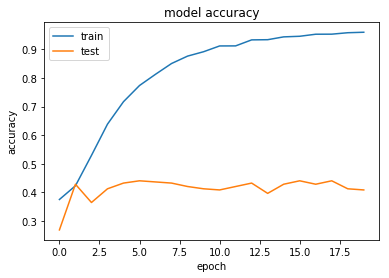

In [286]:
import matplotlib.pyplot as plt

# plot for accuracy from, https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


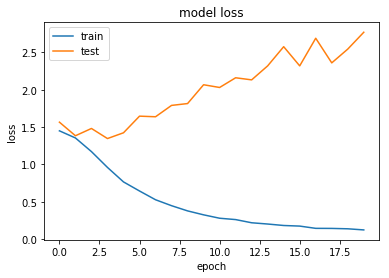

In [287]:
# plot for loss from, https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [288]:
x_test_pre_enc = []

# import test data and pre-process
with open('./data/test.tsv', 'r') as test_data:
    for line in csv.reader(test_data, delimiter='\t'):
        if row_num > 0:
            sentence = re.sub(r'[^a-zA-Z\s]','', line[2])
            words = sentence.lower().split(' ')
            words2 = [word for word in words if ((word not in stop_words) and (word not in other_text_to_remove) and (len(word) > 2))]
            
            if len(words2) > maxlen:
                words2 = words2[:maxlen + 1]
            
            if((len(words2) > 2) and (words2 not in x_test_pre_enc)):
                x_test_pre_enc.append(words2)
        
        row_num += 1
        
test_data.close()

In [289]:
x_test_post_enc = []

# convert test data to indices
for sentence in x_test_pre_enc:
    sentence = [word2index[word] if word in word2index else 0 for word in sentence] 
    x_test_post_enc.append(sentence)

In [290]:
x_test = []

# pad test sentences so everything the same length
x_test = sequence.pad_sequences(x_test_post_enc, maxlen = maxlen)

In [294]:
# print sample test data

x_sample = x_test[:600]
print(x_test_pre_enc[:600])

[['intermittently', 'pleasing', 'mostly', 'routine', 'effort'], ['intermittently', 'pleasing', 'mostly', 'routine'], ['kidman', 'really', 'thing', 'worth', 'watching', 'birthday', 'girl', 'film', 'stagetrained', 'jez', 'butterworth', 'mojo', 'serves', 'yet', 'another', 'example', 'sad', 'decline', 'british', 'comedies', 'postfull', 'monty', 'world'], ['really', 'thing', 'worth', 'watching', 'birthday', 'girl', 'film', 'stagetrained', 'jez', 'butterworth', 'mojo', 'serves', 'yet', 'another', 'example', 'sad', 'decline', 'british', 'comedies', 'postfull', 'monty', 'world'], ['thing', 'worth', 'watching', 'birthday', 'girl', 'film', 'stagetrained', 'jez', 'butterworth', 'mojo', 'serves', 'yet', 'another', 'example', 'sad', 'decline', 'british', 'comedies', 'postfull', 'monty', 'world'], ['worth', 'watching', 'birthday', 'girl', 'film', 'stagetrained', 'jez', 'butterworth', 'mojo', 'serves', 'yet', 'another', 'example', 'sad', 'decline', 'british', 'comedies', 'postfull', 'monty', 'world']

In [292]:
# run prediction on test sample
preds = model.predict(x_sample)

In [293]:
# use argmax to get the category
p_a = [np.argmax(pred) for pred in preds]
print(p_a)

[2, 2, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 4, 4, 4, 4, 4, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 4, 4, 2, 2, 4, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 2, 2, 2, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 4, 2, 2, 2, 